In [14]:
# pip install -U finance-datareader

In [15]:
import FinanceDataReader as fdr

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
# 기존 데이터들과의 합침
# 모델을 호출
import joblib
loaded_model = joblib.load("/content/drive/My Drive/부실기업예측 프로젝트/pred_model/random_logistic.h5")
# 기존에 쓰던 데이터 호출
df = pd.read_csv("/content/drive/My Drive/부실기업예측 프로젝트/data/variable.csv", encoding="utf-8")
df.sector = df.sector.apply(lambda x : "manufacture" if x == 2 else "service")
df_dummy = pd.get_dummies(df['sector']) 
df = pd.concat([df,df_dummy], axis = 1)
# x,y 를 구분
x = df[['x1','x2','x3','x4','om','ga','gs','ge',"manufacture","service"]]
y = df['bankrupt']
# predict_proba 산출
proba = loaded_model.predict_proba(x)
df.code = df.code.map('{:06d}'.format)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:488: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [19]:
proba = pd.DataFrame(proba)
header = df[["name","code","year"]]
header.head()

,name,code,year
0,(주)대유플러스,000300,2011
1,(주)대유플러스,000300,2012
2,(주)대유플러스,000300,2013
3,(주)대유플러스,000300,2014
4,(주)대유플러스,000300,2015


In [20]:
df_proba = pd.concat([header, proba], axis= 1)
df_proba = df_proba.rename(columns ={0:"safe",1:"risk"})

In [21]:
df_proba

,name,code,year,safe,risk
0,(주)대유플러스,000300,2011,0.670745,0.329255
1,(주)대유플러스,000300,2012,0.642268,0.357732
2,(주)대유플러스,000300,2013,0.677681,0.322319
3,(주)대유플러스,000300,2014,0.653684,0.346316
4,(주)대유플러스,000300,2015,0.649679,0.350321
...,...,...,...,...,...
2948,에스비아이핀테크솔루션즈(주),950110,2017,0.708332,0.291668
2949,에스비아이핀테크솔루션즈(주),950110,2018,0.725251,0.274749
2950,에스비아이핀테크솔루션즈(주),950110,2019,0.699564,0.300436
2951,에스비아이핀테크솔루션즈(주),950110,2020,0.723569,0.276431


In [22]:
# 미 10년 국채 수익률
df_rate = fdr.DataReader("US10YT=X","2010-01-01","2021-12-01")
df_rate = df_rate[["Close"]]
df_rate = df_rate.rename(columns={"Close":"free_rate"})
df_rate

,free_rate
Date,
2010-01-04,3.823
2010-01-05,3.763
2010-01-06,3.829
2010-01-07,3.827
2010-01-08,3.836
...,...
2021-11-26,1.482
2021-11-28,1.531
2021-11-29,1.502


In [23]:
def calcualtion(name,stock):
    stock = pd.merge(stock,df_rate,how="inner",on="Date")
    stock["risk_free"] = stock["free_rate"]/36500
    stock["risk_return"] = stock["Change"]-stock["risk_free"]
    stock['rtn'] = (1+stock['Change']).cumprod()
    historical_max = stock['Close'].cummax()
    daily_drawdown = stock['Close'] / historical_max - 1.0
    historical_dd = daily_drawdown.cummin()
    mdd = historical_dd.min()
    cagr = stock.iloc[len(stock)-1].rtn ** (252./len(stock)) -1
    sharpe = (np.mean(stock['risk_return']) / np.std(stock['Change'])) * np.sqrt(252)
    data_to_insert = {'code': name, 'cagr': cagr, 'mdd': mdd, 'sharpe': sharpe,}
    return data_to_insert

In [24]:
# 모든 주식의 수치 계산
lost = list()
result = pd.DataFrame(columns = ["code","cagr","sharpe","mdd"])
for i in df_proba.code.unique():
    num_list = []
    stock = fdr.DataReader(i,'2010-01-01','2020-12-31')

    if len(stock) != 0:
        data_to_insert = calcualtion(i,stock)
        result = result.append(data_to_insert, ignore_index = True)

    else :
        lost.append(i)

In [25]:
result1 = result.copy()

In [26]:
# for i in range(len(result)):
#     outcome = result.iloc[i]
#     print('CAGR : ',round(outcome[1]*100,2),'%')
#     print('Sharpe : ',round(outcome[2],2))
#     print('MDD : ',round(-1*outcome[3]*100,2),'%')

In [27]:
print(len(lost))
lost
#이 친구들은 이 전에 상폐된 친구들이다 = 데이터가 없다 => 근데 이건 2010년으로 확장하면서 의미가 없어진 코드다

0


[]

In [28]:
result1[result1.cagr >= 3] #그냥 특이한 거 보고 싶었음 (*300배)

,code,cagr,sharpe,mdd
441,336370,7.373798,2.794654,-0.506003


In [29]:
# def labeling(df,target,x,y):
#     codes = df[(df.risk >= x) & (df.risk <= y) ].code.unique()
#     another_codes = df[df.risk >= y].code.unique()
#     # 라벨링
#     target["portfolio"] = target["code"].apply(lambda x: 2 if x in another_codes else 1 if x in codes else 0)
#     return target

# import random
# random.seed(42)
# calcul = pd.DataFrame()
# for i in range(1000):
#     x = random.uniform(0,1)
#     y = random.uniform(x,1)
#     result2 = labeling(df_proba, result1,x,y)
#     one = result2[result2.portfolio == 0].cagr.mean()
#     two = result2[result2.portfolio == 1].cagr.mean()
#     differ = two - one
#     to_insert = {'x': x, 'y': y, 'differ': differ}
#     calcul = calcul.append(to_insert, ignore_index = True)
# calcul[calcul.differ == calcul.differ.max()]

In [33]:
# 위험율 계산 완료 및 포트폴리오 기준 선정
low_rate = df_proba.risk.quantile(0.33)
high_rate = df_proba.risk.quantile(0.66)
print(low_rate, high_rate)
def labeling(df,target):
    codes = df[(df.risk >= low_rate) & (df.risk <= high_rate) ].code.unique()
    another_codes = df[df.risk >= high_rate].code.unique()
    # 라벨링
    target["portfolio"] = target["code"].apply(lambda x: 2 if x in another_codes else 1 if x in codes else 0)
    return target

0.1732295375537376 0.31902459406388706


In [34]:
result2 = labeling(df_proba, result1)
result2.portfolio.value_counts()

2    252
1    114
0     78
Name: portfolio, dtype: int64

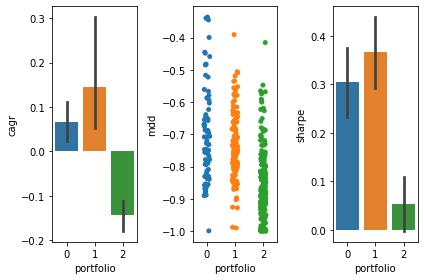

In [35]:
fig, ax = plt.subplots(ncols = 3)
sns.barplot(x="portfolio", y="cagr", data=result2, ax = ax[0])
sns.stripplot(x="portfolio", y="mdd", data=result2, ax = ax[1])
sns.barplot(x="portfolio", y="sharpe",data = result2, ax= ax[2])
plt.savefig('/content/drive/My Drive/부실기업예측 프로젝트/backtesting.png')
plt.tight_layout()

In [36]:
# 코스피200 it 섹터 인덱스 계산
market = fdr.DataReader("KS200IT", "2010-01-01","2020-12-31")
market_index = calcualtion("KS200IT",market)
market_index

{'cagr': 0.13798433951168998,
 'code': 'KS200IT',
 'mdd': -0.3719455147421039,
 'sharpe': 0.652122565784014}

In [37]:
market2 = fdr.DataReader("069500","2010-01-01","2020-12-31")
market_index2 = calcualtion("069500",market2)
market_index2

{'cagr': 0.06905073254006355,
 'code': '069500',
 'mdd': -0.38084320468730093,
 'sharpe': 0.3851509065464332}

In [38]:
print("0그룹 평균 CAGR 값 : %.4f" % result2[result2.portfolio == 0].cagr.mean())
print("1그룹 평균 CAGR 값 : %.4f" % result2[result2.portfolio == 1].cagr.mean())
print("2그룹 평균 CAGR 값 : %.4f" % result2[result2.portfolio == 2].cagr.mean())
print("0그룹 평균 Sharpe 값 : %.2f" % result2[result2.portfolio == 0].sharpe.mean())
print("1그룹 평균 Sharpe 값 : %.2f" % result2[result2.portfolio == 1].sharpe.mean())
print("2그룹 평균 Sharpe 값 : %.2f" % result2[result2.portfolio == 2].sharpe.mean())
print("0그룹 평균 MDD 값 : %.2f" % result2[result2.portfolio == 0].mdd.mean())
print("1그룹 평균 MDD 값 : %.2f" % result2[result2.portfolio == 1].mdd.mean())
print("2그룹 평균 MDD 값 : %.2f" % result2[result2.portfolio == 2].mdd.mean())

0그룹 평균 CAGR 값 : 0.0657
1그룹 평균 CAGR 값 : 0.1441
2그룹 평균 CAGR 값 : -0.1442
0그룹 평균 Sharpe 값 : 0.30
1그룹 평균 Sharpe 값 : 0.37
2그룹 평균 Sharpe 값 : 0.05
0그룹 평균 MDD 값 : -0.70
1그룹 평균 MDD 값 : -0.73
2그룹 평균 MDD 값 : -0.87


작성해야 할 코드
1. 평균 수익률 간의 차이를 확실하게 벌릴 수 있는 값을 찾아야 한다(다만 95% 설정해 주고 평균 비교)

3. 연도별 각각의 수익률 계산하는 방식 / 
1) 우선 해당 년도별 기업 추출 
2) 조건에 맞는 지 확인
3) 맞으면 buy 에 해당하므로 사는 거 진행
4) 이후 1년 뒤 각각의 수익률 계산 => 업종에 모두 비례하게 투자할 계획 / 즉 1/n하면 됨 
5) portfolio 일별 수익률 계산 완료 /
6) 5년 전체 수익률 계산 가능

In [39]:
# 우선 연도별로 대상 회사들을 추출
def port_calcul(group_num,term=1, ):
    portfolio = pd.DataFrame(columns = ["code","cagr","sharpe","mdd"])
    df_change = pd.DataFrame()
    for i in range(0,10,term):
        df_year = df_proba.copy()[df_proba.year == 2010+i]
    # 우리 기준에 합당하는 회사들만 투자
        df_label = labeling(df_year,df_year)
        df_target = df_label[df_label.portfolio == group_num]
        print(f"20{i+10}년 투자 종목 수 : ",len(df_target.code.unique()))
        df_now = pd.DataFrame()
        for j in df_target.code.unique():
            num_list = []
            if (i+9+term) >= 20:
                stock = fdr.DataReader(j,f'20{i+10}-01-01','2020-12-31')
            else :
                stock = fdr.DataReader(j,f'20{i+10}-01-01',f'20{i+9+term}-12-31')
            if len(stock) != 0:
                change = stock[["Change"]]
                change = change.rename(columns = {"Change":f"{j}"})
                df_now = pd.concat([df_now, change],axis = 1)
        df_change = pd.concat([df_change,df_now]) # 여기 수정하면 전체 기간 동안의 거 계산 가능
    df_change = df_change.fillna(0)
    print(df_change.shape)
    # 변화량과 종가의 합으로 포트폴리오 계산
    df_change["Change"] = df_change.sum(axis =1)
    df_change = df_change[["Change"]]
    df_change = pd.merge(df_change,df_rate,how="inner",on="Date")
    df_change["risk_free"] = df_change["free_rate"]/365
    df_change["risk_return"] = df_change["Change"]-df_change["risk_free"]
    df_change['rtn'] = (1+df_change['Change']/100).cumprod()
    # 종가를 return에서 다시 역산
    df_change["Close"] = df_change["rtn"]*100
    historical_max = df_change['Close'].cummax()
    daily_drawdown = df_change['Close'] / historical_max - 1.0
    historical_dd = daily_drawdown.cummin()
    mdd = historical_dd.min()
    cagr = df_change.iloc[len(df_change)-1].rtn ** (252./len(df_change)) -1
    sharpe = (np.mean(df_change['risk_return']) / np.std(df_change['Change'])) * np.sqrt(252)
    data_to_insert = {'code': f"20{i+10}", 'cagr': cagr, "mdd" : mdd, 'sharpe': sharpe,}
    portfolio = portfolio.append(data_to_insert, ignore_index = True)
    return portfolio, df_change

In [40]:
yes_finally2, df01 = port_calcul(0,1)
yes_finally2

2010년 투자 종목 수 :  37
2011년 투자 종목 수 :  65
2012년 투자 종목 수 :  65
2013년 투자 종목 수 :  74
2014년 투자 종목 수 :  89
2015년 투자 종목 수 :  99
2016년 투자 종목 수 :  102
2017년 투자 종목 수 :  95
2018년 투자 종목 수 :  113
2019년 투자 종목 수 :  120
(2466, 191)


,code,cagr,sharpe,mdd
0,2019,0.134636,0.766151,-0.335237


In [41]:
yes_finally, df11 = port_calcul(1,1)
yes_finally

2010년 투자 종목 수 :  50
2011년 투자 종목 수 :  97
2012년 투자 종목 수 :  96
2013년 투자 종목 수 :  74


KeyboardInterrupt: ignored

In [ ]:
yes_finally3, df21 = port_calcul(2,1)
yes_finally3

2010년 투자 종목 수 :  43
2011년 투자 종목 수 :  79
2012년 투자 종목 수 :  74
2013년 투자 종목 수 :  88
2014년 투자 종목 수 :  86
2015년 투자 종목 수 :  78
2016년 투자 종목 수 :  91
2017년 투자 종목 수 :  105
2018년 투자 종목 수 :  112
2019년 투자 종목 수 :  117
(2466, 227)


,code,cagr,sharpe,mdd
0,2019,0.011072,0.062017,-0.464519


In [ ]:
fucking, df03 = port_calcul(0,3)
fucking

2010년 투자 종목 수 :  37
2013년 투자 종목 수 :  74
2016년 투자 종목 수 :  102
2019년 투자 종목 수 :  120
(2714, 158)


,code,cagr,sharpe,mdd
0,2019,0.138279,0.704994,-0.490764


In [ ]:
fucking1, df13 = port_calcul(1,3)
fucking1

2010년 투자 종목 수 :  50
2013년 투자 종목 수 :  74
2016년 투자 종목 수 :  92
2019년 투자 종목 수 :  96
(2714, 186)


,code,cagr,sharpe,mdd
0,2019,0.128128,0.663279,-0.450241


In [ ]:
fucking2, df23 = port_calcul(2,3)
fucking2

2010년 투자 종목 수 :  43
2013년 투자 종목 수 :  88
2016년 투자 종목 수 :  91
2019년 투자 종목 수 :  117
(2714, 195)


,code,cagr,sharpe,mdd
0,2019,0.035648,0.198638,-0.597819


In [ ]:
yesyes, df05 = port_calcul(0,5)
yesyes

2010년 투자 종목 수 :  37
2015년 투자 종목 수 :  99
(2466, 111)


,code,cagr,sharpe,mdd
0,2015,0.070806,0.459719,-0.307431


In [ ]:
yesyes1, df15 = port_calcul(1,5)
yesyes1

2010년 투자 종목 수 :  50
2015년 투자 종목 수 :  86
(2466, 109)


,code,cagr,sharpe,mdd
0,2015,0.083273,0.516784,-0.307625


In [ ]:
yesyes2, df23 = port_calcul(2,5)
yesyes2

2010년 투자 종목 수 :  43
2015년 투자 종목 수 :  78
(2466, 103)


,code,cagr,sharpe,mdd
0,2015,0.009418,0.001578,-0.3176


In [ ]:
def create_trade_book(sample):
    book = sample[['Change']].copy()
    book['trade'] = ''
    return (book)    
# 5가 20을 밑에서 뚫으면 산다
# 5가 20 밑으로 내려앉으면 판다

# 5가 20보다 위면 산거 유지
# 5가 20보다 아래면 안 산다

def tradings(sample, book):
    for i in sample.index:
        if sample.loc[i, 'roll5'] > sample.loc[i, 'roll20'] and sample.shift(1).loc[i, 'roll5'] < sample.shift(1).loc[i, 'roll20']: 
            # 5가 20을 밑에서 뚫으면 산다
            book.loc[i, 'trade'] = "buy"
        elif sample.loc[i, 'roll5'] < sample.loc[i, 'roll20'] and sample.shift(1).loc[i, 'roll5'] > sample.shift(1).loc[i, 'roll20']:
            # 5가 20보다 내려앉으면 판다
            book.loc[i, 'trade'] = '0'
        else:
            if sample.loc[i,'roll5'] >= sample.loc[i, 'roll20']:
                # 5가 높으면 계속 유지
                book.loc[i, 'trade'] = 'buy'
            elif sample.loc[i,'roll5'] < sample.loc[i,'roll20']:
                # 5가 20보다 낮으면 현상 유지
                book.loc[i,'trade'] = '0'
    return (book)

In [ ]:
def moving_trade(group_num,term=1,):
    portfolio = pd.DataFrame(columns = ["code","cagr","sharpe","mdd"])
    df_change = pd.DataFrame()

    for k in range(0,10,term):
        df_year = df_proba.copy()[df_proba.year == 2010+k]
    # 우리 기준에 합당하는 회사들만 투자
        df_label = labeling(df_year,df_year)
        df_target = df_label[df_label.portfolio == group_num]
        print(f"20{k+10}년 투자 종목 수 : ",len(df_target.code.unique()))
        df_now = pd.DataFrame()
        df_move = pd.DataFrame()
        for j in df_target.code.unique():
            if k+10+term >= 20:
                stock = fdr.DataReader(j,f'20{k+10}-01-01','2020-12-31')
            else :
                stock = fdr.DataReader(j,f'20{k+10}-01-01',f'20{k+9+term}-12-31')
            if len(stock) != 0:
                change = stock[["Close","Change"]]
                change["roll5"] = change["Close"].rolling(5).mean()
                change["roll20"] = change["Close"].rolling(20).mean()
                book = create_trade_book(change)
                book = tradings(change,book)
                book['return'] = ''
                for i in book.index:
                    if book.loc[i,'trade'] == 'buy':
                        book.loc[i,'return'] = book.loc[i,'Change']
                    elif book.loc[i,'trade'] == '0':
                        book.loc[i,'return'] = 0
                    else :
                        book.loc[i,'return'] = 0
            book = book[["return"]]
            book = book.rename(columns={'return':j})
            df_move = pd.concat([df_move,book], axis = 1)
        df_change = pd.concat([df_change,df_move])
    df_change = df_change.fillna(0)
    print(df_change.shape)

    # 변화량과 종가의 합으로 포트폴리오 계산
    df_change["Change"] = df_change.sum(axis =1)
    df_change = df_change[["Change"]]
    df_change = pd.merge(df_change,df_rate,how="inner",on="Date")
    df_change["risk_free"] = df_change["free_rate"]/365
    df_change["risk_return"] = df_change["Change"]-df_change["risk_free"]
    df_change['rtn'] = (1+df_change['Change']/100).cumprod()
    # 종가를 return에서 다시 역산
    df_change["Close"] = df_change["rtn"]*100
    historical_max = df_change['Close'].cummax()
    daily_drawdown = df_change['Close'] / historical_max - 1.0
    historical_dd = daily_drawdown.cummin()
    mdd = historical_dd.min()
    cagr = df_change.iloc[len(df_change)-1].rtn ** (252./len(df_change)) -1
    sharpe = (np.mean(df_change['risk_return']) / np.std(df_change['Change'])) * np.sqrt(252)
    data_to_insert = {'code': f"20{k+10}", 'cagr': cagr, "mdd" : mdd, 'sharpe': sharpe,}
    portfolio = portfolio.append(data_to_insert, ignore_index = True)
    print(portfolio)
    return portfolio, df_change




In [ ]:
nothing, df01 = moving_trade(0,1)
nothing

2010년 투자 종목 수 :  37


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2011년 투자 종목 수 :  65


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2012년 투자 종목 수 :  65


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2013년 투자 종목 수 :  74


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2014년 투자 종목 수 :  89


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2015년 투자 종목 수 :  99


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2016년 투자 종목 수 :  102


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2017년 투자 종목 수 :  95


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018년 투자 종목 수 :  113


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2019년 투자 종목 수 :  120


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


   code      cagr   sharpe       mdd
0  2019  0.287443  2.82743 -0.062932


,code,cagr,sharpe,mdd
0,2019,0.287443,2.82743,-0.062932


In [ ]:
nothing1, df11 = moving_trade(1,1)
nothing1

2010년 투자 종목 수 :  50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2011년 투자 종목 수 :  97


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2012년 투자 종목 수 :  96


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2013년 투자 종목 수 :  74


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2014년 투자 종목 수 :  72


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2015년 투자 종목 수 :  86


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2016년 투자 종목 수 :  92


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2017년 투자 종목 수 :  106


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018년 투자 종목 수 :  96


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2019년 투자 종목 수 :  96


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


   code      cagr    sharpe       mdd
0  2019  0.286804  2.774739 -0.079093


,code,cagr,sharpe,mdd
0,2019,0.286804,2.774739,-0.079093


In [ ]:
nothing2, df21 = moving_trade(2,1)
nothing2

2010년 투자 종목 수 :  43


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2011년 투자 종목 수 :  79


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2012년 투자 종목 수 :  74


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2013년 투자 종목 수 :  88


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2014년 투자 종목 수 :  86


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2015년 투자 종목 수 :  78


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2016년 투자 종목 수 :  91


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2017년 투자 종목 수 :  105


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2018년 투자 종목 수 :  112


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2019년 투자 종목 수 :  117


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


   code      cagr    sharpe       mdd
0  2019  0.294347  3.073247 -0.069848


,code,cagr,sharpe,mdd
0,2019,0.294347,3.073247,-0.069848


In [ ]:
noman, df03 = moving_trade(0,3)
noman

2010년 투자 종목 수 :  37


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2013년 투자 종목 수 :  74


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2016년 투자 종목 수 :  102


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2019년 투자 종목 수 :  120


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


   code      cagr    sharpe       mdd
0  2019  0.267704  2.796651 -0.062932


,code,cagr,sharpe,mdd
0,2019,0.267704,2.796651,-0.062932


In [ ]:
yesman1, df13 = moving_trade(1,3)
yesman1

2010년 투자 종목 수 :  50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2013년 투자 종목 수 :  74


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2016년 투자 종목 수 :  92


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2019년 투자 종목 수 :  96


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


   code      cagr    sharpe       mdd
0  2019  0.265408  2.903989 -0.058749


,code,cagr,sharpe,mdd
0,2019,0.265408,2.903989,-0.058749


In [ ]:
yesman2, df23 = moving_trade(2,3)
yesman2

2010년 투자 종목 수 :  43


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2013년 투자 종목 수 :  88


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2016년 투자 종목 수 :  91


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


2019년 투자 종목 수 :  117


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
